In [1]:
import scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import math

In [2]:
fDF = pd.read_csv('Data/featureTypes.txt', names=['featureID'])

In [3]:
print fDF.shape
print fDF['featureID'][0]
n = 10000
d = 3000

(3000, 1)
flavors raspberries cherries


In [4]:
trainDF = pd.read_csv('Data/trainData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
YDF = pd.read_csv('Data/trainLabels.txt', names = ['label'])
valXDF = pd.read_csv('Data/valData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
valYDF = pd.read_csv('Data/valLabels.txt', names = ['label'])
print trainDF.shape[0]

247847


In [5]:
W = np.random.rand(d)  #random.uniform(low=0.0, high=1.0,size = (d,))
B = 0 #np.zeros(n)
TempBArray = np.ones(n)
print W.shape
#print TempBArray
print np.count_nonzero(W)
print len(W)
print W

(3000,)
3000
3000
[ 0.58267494  0.51174942  0.11432714 ...,  0.58769239  0.25534512
  0.07041882]


In [6]:
trainDF[:5]

,instanceID,featureID,value
0,1,13,0.209
1,1,83,0.209
2,1,228,0.209
3,1,242,0.209
4,1,371,0.209


In [7]:
#tDF = csr_matrix(trainDF) 
#print tDF[:5]

In [8]:
#sdf = pd.SparseDataFrame(tDF)
#print sdf[:5]

In [9]:
# Will lead to negative index if re-running
trainDF['instanceID'] -= 1
trainDF['featureID'] -= 1
sMat = csr_matrix((trainDF['value'], (trainDF['featureID'], trainDF['instanceID'])))
valXDF['instanceID'] -= 1
valXDF['featureID'] -= 1
valX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
Y = YDF['label'].as_matrix().transpose()
#print Y.shape
valY = valYDF['label'].as_matrix().transpose()

In [10]:
#print sMat.shape
#print sMat.todense()
print sMat.max(), sMat.min()

0.728 0.0


In [11]:
#print sMat[:2]

In [12]:
X = sMat.copy()
print X.shape

(3000, 10000)


In [13]:
print len(W.nonzero())
print len(W)

1
3000


In [14]:
def initLamda(X, Y):
    YNorm = Y - float(Y.sum())/((float)(Y.shape[0]))
    return 2 * (abs(X * YNorm).max())
    
print initLamda(X, Y)

1271.869651


In [15]:
t = X.copy()
t.data **= 2
At = 2*t.sum(axis = 1)
print At

[[ 0.731852]
 [ 2.660682]
 [ 1.581472]
 ..., 
 [ 1.564942]
 [ 2.31796 ]
 [ 1.5809  ]]


In [16]:
redFact = 0.1

In [17]:
# change this to convergence condition

def rmse(input1, input2):
    out = input1 - input2
    #print out
    out **= 2
    out /= len(out)
    error = out.sum()
    return math.sqrt(error)


class Lasso:
    def __init__(self, X, Y, W, B, Lamda):
        self.X = X.copy()
        self.Y = Y.copy()
        self.W = W #.copy()  # Remove this copy later
        self.B = B #.copy()
        t = X.copy()
        t.data **= 2
        self.A = 2*t.sum(axis = 1)
        self.Lamda = Lamda
        self.delta = 0.001
        # Stores Lamda and respective RMSE
        self.trainrmse = []
        self.trainlamda = []
        self.valrmse = []
        self.vallamda = []
        self.NonZero = []
        
    def loss(self):
        return ((self.X.transpose() * self.W + self.B - self.Y) ** 2).sum() + self.Lamda * (abs(self.W)).sum()
        
    def fit(self):
        # Lamda = initLamda(self.X, self.Y)
        
        #print X.shape, W.shape
        #for epoch in range(100):
        oldLoss = self.loss()+2
        newLoss = self.loss()
        print 'Lamda: ', self.Lamda
        while oldLoss - newLoss > self.delta:
        #for i in range(1000):
            #print sMat.transpose() * W
            # 4.1.1
            #print t1[:5], t1.shape
            #print t1.shape, B.shape, Y.shape
            XTW = (self.X.transpose() * self.W)
            R = self.Y - (self.X.transpose() * self.W) - self.B
            
            # 4.1.2
            BOld = self.B
            self.B = np.full(n, (R + self.B).sum() / n) 
            #print self.B
            #print self.B.shape
            #self.B = (self.Y - XTW).sum() / n
            #print B.shape
            # 4.1.3
            R =  R + BOld - self.B
            #print 'RSHAPE', R.shape
            #print 'R', R
            #R = self.Y - (XTW + self.B)
            #print R.shape
            #print R[:5]
            # R = R.reshape(-1)
            for ik in range(0, d):
                # 4.1.4
                #ik = 0
                t = (self.X[ik].transpose() * self.W[ik]).toarray().reshape(-1)
                #print t
                #print t.shape
                #print R.shape
                Ck = 2*( self.X[ik] * (R + t)).sum()
                #print 'CK:', Ck
                # Update Weight
                WkOld = self.W[ik]
                #print 'OW: ', WkOld
                if Ck < -self.Lamda:
                    self.W[ik] = (Ck + self.Lamda) / self.A[ik]
                elif Ck > self.Lamda:
                    self.W[ik] = (Ck - self.Lamda) / self.A[ik]
                else:
                    self.W[ik] = 0
                #print 'W: ', WkOld, self.W[ik]
                #print W[ik]
                # 4.1.5
                # print self.W[ik], WkOld
                #print X[ik].toarray().reshape(-1).shape, R.shape
                R = R + self.X[ik].toarray().reshape(-1) * (WkOld - self.W[ik])
                #R = self.Y - (self.X.transpose() * self.W) + self.B
            oldLoss = newLoss
            newLoss = model.loss()
            #print oldLoss, newLoss, oldLoss - newLoss
            print 'LOSS:' , newLoss
            # End of feature vector iterator
    
    def saveModel(self, filename):
        pickle.dump(self, open( filename, "wb" ))
    
    def predict(self, X):
        return (X.transpose() * self.W + np.full(X.transpose().shape[0], self.B))
    
    def chooseCorrectLamda(self, delta = -1):
        oldLamda = self.Lamda
        if delta != -1:
            self.delta = delta
        self.fit()
        
        newRMSE = rmse(self.predict(self.X), self.Y)
        #self.TrainInfo.append([self.Lamda, newRMSE])
        self.trainrmse.append(newRMSE)
        self.trainlamda.append(self.Lamda)
        valRMSE = rmse(self.predict(valX), valY)
        self.valrmse.append(valRMSE)
        self.vallamda.append(self.Lamda)
        oldRMSE = valRMSE
        #print W
        #self.ValInfo.append([self.Lamda, valRMSE])
        self.NonZero.append((self.W != 0.0).sum())
        print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
        
        while valRMSE >= 1.94673083676 and self.Lamda > 2.8:
            oldLamda = self.Lamda
            self.Lamda -= redFact
            self.fit()
            oldRMSE = valRMSE
            #self.TrainInfo.append([self.Lamda, newRMSE])
            newRMSE = rmse(self.predict(self.X), self.Y)
            self.trainrmse.append(newRMSE)
            self.trainlamda.append(self.Lamda)
            valRMSE = rmse(self.predict(valX), valY)
            #self.ValInfo.append([self.Lamda, valRMSE])
            self.valrmse.append(valRMSE)
            self.vallamda.append(self.Lamda)
            self.NonZero.append(np.count_nonzero(self.W))
            #self.NonZero.append(self.W.toarray().count_nonzero())
            print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
            self.saveModel('optimal_saved_Model')
            
    
def loadModel(filename):
    return pickle.load(open(filename, "rb" ))

In [18]:
model = Lasso(X, Y, W, B, 3) #initLamda(X.copy(), Y.copy()))
#model.loss()
#model.fit()

In [19]:
print model.Lamda

3


In [20]:
#model.Lamda = 2.48
model.chooseCorrectLamda()

Lamda:  3
LOSS: 53269.1962343
LOSS: 38871.8566748
LOSS: 36554.7541936
LOSS: 35907.6340522
LOSS: 35669.4808321
LOSS: 35565.4195014
LOSS: 35511.9434556
LOSS: 35478.5745662
LOSS: 35452.4018023
LOSS: 35428.9806017
LOSS: 35407.5009913
LOSS: 35387.1110179
LOSS: 35367.2926526
LOSS: 35347.7184139
LOSS: 35328.1718088
LOSS: 35308.497937
LOSS: 35288.5132767
LOSS: 35268.0793061
LOSS: 35247.0985055
LOSS: 35225.6180971
LOSS: 35203.6407452
LOSS: 35181.2904933
LOSS: 35158.7594197
LOSS: 35136.2874694
LOSS: 35114.1068367
LOSS: 35092.4274881
LOSS: 35071.6095228
LOSS: 35051.9029924
LOSS: 35033.3950647
LOSS: 35016.1071029
LOSS: 34999.9972368
LOSS: 34985.0213194
LOSS: 34971.1108447
LOSS: 34958.2047029
LOSS: 34946.2292251
LOSS: 34935.1377416
LOSS: 34924.855624
LOSS: 34915.2896124
LOSS: 34906.3723599
LOSS: 34898.0379287
LOSS: 34890.2232364
LOSS: 34882.8726675
LOSS: 34875.9500297
LOSS: 34869.4467601
LOSS: 34863.331331
LOSS: 34857.5688261
LOSS: 34852.13237
LOSS: 34846.9996275
LOSS: 34842.1524709
LOSS: 34837.584

In [21]:
#model.Lamda = 2.2
#model.chooseCorrectLamda()

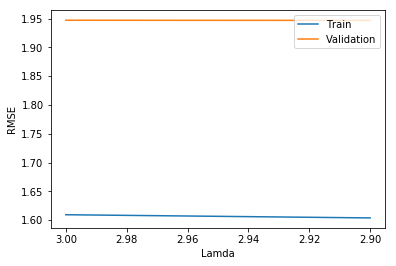

In [22]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

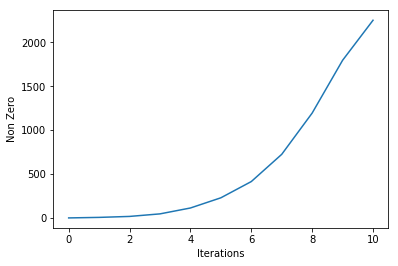

[0, 6, 17, 46, 113, 229, 414, 724, 1194, 1795, 2251]
2251


In [24]:
import matplotlib.pyplot as plt
plt.plot(model.NonZero)
plt.ylabel('Non Zero')
plt.xlabel('Iterations')
#plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print model.NonZero
print np.count_nonzero(model.W)
#plt.savefig('NonZeroElements.png')

In [21]:
model.saveModel('savedModeltill3')

In [23]:
#print model.lamda
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY

1.94672165377
83.1728870133
[ 91.39059689  92.86065898  87.60289719 ...,  91.57614772  88.28201764
  91.24482434]
[92 90 86 ..., 92 89 88]


In [28]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
testX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
testPredicted = model.predict(testX)
print testPredicted
np.savetxt("out3.csv", testPredicted, delimiter=",")
#testPredicted.to_csv('out.csv')

[ 105.71206656   85.54415933   87.60385796 ...,   87.82942353   87.01643808
   85.78716094]


In [ ]:
# Mixture
bigData = (X + valX) / 2


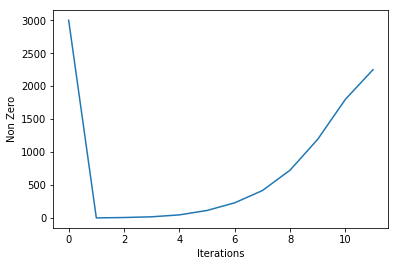

In [56]:
#loadedModel = loadModel('./finalData/savedModel')
#plt.plot(loadedModel.NonZero)
#plt.ylabel('Non Zero')
#plt.xlabel('Iterations')
#plt.show()

In [71]:
#print loadedModel.W
#WLoaded = list(loadedModel.W)
#sorted(range(len(WLoaded)), key=lambda i: WLoaded[i])[-10:]
#print WLoaded[2468]
#print max(WLoaded)

[ 0.          3.70430265  5.27646819 ..., -0.17621468  0.91925534
  1.82692104]
8.76831112942
11.2180665852


In [1]:
#print loadedModel.trainlamda[1:]
#print loadedModel.trainrmse.shape
#plt.plot(loadedModel.trainlamda[1:], loadedModel.trainrmse)
#plt.plot(loadedModel.vallamda[1:], loadedModel.valrmse)
#lt.ylabel('RMSE')
#plt.xlabel('Lamda')
#ax = plt.gca()
##ax.invert_xaxis()
##plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()

In [25]:
model.Lamda

2.9

In [24]:
valModel = Lasso(valX, valY, W, B, model.Lamda)


In [26]:
#valModel.Lamda = 2.4466

valModel.fit()

Lamda:  2.9
LOSS: 45146.9132038
LOSS: 46021.4850961


In [3]:
#print model.lamda
#print rmse(model.predict(valX), valY)
#print rmse(X.transpose() * model.W, valY)
#print model.predict(valX)
#print valY
#print rmse(valY, (valModel.X.transpose() * valModel.W) + np.full(valModel.X.transpose().shape[0], valModel.B[0]))
#print rmse(Y, (X.transpose() * valModel.W) + np.full(X.transpose().shape[0], valModel.B[0]))


In [27]:
#print model.lamda
#print rmse(model.predict(valX), valY)
#print rmse(X.transpose() * model.W, valY)
##print model.predict(valX)
#print valY
print rmse(valY, (valModel.X.transpose() * valModel.W) + np.full(valModel.X.transpose().shape[0], valModel.B[0]))
print rmse(Y, (X.transpose() * valModel.W) + np.full(X.transpose().shape[0], valModel.B[0]))


1.60860363394
1.92251457265


In [43]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
#testXDF['instanceID'] -= 1
testXDF['featureID'] -= 1
testX = csr_matrix((testXDF['value'], (testXDF['featureID'], testXDF['instanceID'])))
print testX.shape[0]
testPredicted = (testX.transpose() * valModel.W) + np.full(testX.transpose().shape[0], valModel.B[0])
#np.full(X.transpose().shape[0], self.B)
#testPredicted = valModel.predict(testX)
print testPredicted
np.savetxt("out4.csv", testPredicted, delimiter=",")

3000
[ 83.02883713  90.73658781  82.728051   ...,  88.27508323  87.98656016
  87.20594529]


In [78]:
#from sklearn import linear_model
#clf = linear_model.Lasso(alpha=0.1)
#clf.fit(valX.transpose(), valY)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
#print clf.predict(valX.transpose()).shape
#print rmse(valY, clf.predict(valX.transpose()))

(10000,)
3.38956530546


In [39]:
t1 = pd.read_csv('./out1.csv', sep=',')
t2 = pd.read_csv('./out2.csv', sep=',')
t3 = pd.read_csv('./out3.csv', sep=',')
t4 = pd.read_csv('./out4.csv', sep=',')

#print t1

In [42]:
print rmse(t1['Points'], t2['Points'])
print rmse(t2['Points'], t4['Points'])
print rmse(t3['Points'], t4['Points'])
print rmse(t1['Points'], t4['Points'])

0.609417268055
4.1856067531
3.99020762352
4.04321606822
